# 1. 라이브러리 호출

In [1]:
import pandas as pd
import numpy as np
import pandas_profiling.profile_report

import re
import seaborn as sns
sns.set(style = 'white')

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick # For specifying the axes tick format 
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Label Encoding
from sklearn.preprocessing import LabelEncoder

/Users/minkim/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/minkim/anaconda3/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/minkim/anaconda3/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference

# 2. 데이터 확인

##### 데이터 호출

In [2]:
df = pd.read_csv('churn.csv', encoding='euc-kr')
df.head()
# df.profile_report()

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


##### 컬럼 이름 재설정 (용어정리)

In [3]:
df.rename(lambda x: x.lower().strip().replace(' ', '_'), axis='columns', inplace=True)
df.columns

Index(['customer_id', 'gender', 'age', 'married', 'number_of_dependents',
       'city', 'zip_code', 'latitude', 'longitude', 'number_of_referrals',
       'tenure_in_months', 'offer', 'phone_service',
       'avg_monthly_long_distance_charges', 'multiple_lines',
       'internet_service', 'internet_type', 'avg_monthly_gb_download',
       'online_security', 'online_backup', 'device_protection_plan',
       'premium_tech_support', 'streaming_tv', 'streaming_movies',
       'streaming_music', 'unlimited_data', 'contract', 'paperless_billing',
       'payment_method', 'monthly_charge', 'total_charges', 'total_refunds',
       'total_extra_data_charges', 'total_long_distance_charges',
       'total_revenue', 'customer_status', 'churn_category', 'churn_reason'],
      dtype='object')

In [4]:
# create 'churn' col
df['churn'] = np.where(df['customer_status'] == 'Churned', 'Yes', 'No')

##### 중복값 확인 및 제거

In [5]:
df.duplicated('customer_id', keep=False).sum()

0

##### 결측치 확인 및 정리

In [6]:
df.isnull().sum()
# df.isnull().sum().to_frame('nan_count')

customer_id                             0
gender                                  0
age                                     0
married                                 0
number_of_dependents                    0
city                                    0
zip_code                                0
latitude                                0
longitude                               0
number_of_referrals                     0
tenure_in_months                        0
offer                                   0
phone_service                           0
avg_monthly_long_distance_charges     682
multiple_lines                        682
internet_service                        0
internet_type                        1526
avg_monthly_gb_download              1526
online_security                      1526
online_backup                        1526
device_protection_plan               1526
premium_tech_support                 1526
streaming_tv                         1526
streaming_movies                  

**결측치 큰 컬럼**
1. 철회 이유와 카테고리
    - 철회 고객 한정 공란
2. 인터넷 서비스 관련 종속 컬럼
    - 인터넷 서비스 구독 안하는 고객 한정 공란
    - 인터넷 서비스 구독 안하는 고객이 1526명이다.
3. 핸드폰 서비스 관련 종속 컬럼
    - 핸드폰 서비스 구독 안하는 고객 한정 공란
    - 핸드폰 서비스를 구독 안하는 고객이 682명이다.

In [7]:
df['avg_monthly_long_distance_charges'] = df['avg_monthly_long_distance_charges'].fillna(round(df['avg_monthly_long_distance_charges'].mean()))
df.multiple_lines = df.multiple_lines.fillna('No Phone Service')

In [8]:
no_internet_service = ['internet_type', 'online_security', 'online_backup', 'device_protection_plan','premium_tech_support',
                       'streaming_tv', 'streaming_movies', 'streaming_music', 'unlimited_data']
df[no_internet_service] = df[no_internet_service].fillna('No Internet Service')
df['avg_monthly_gb_download'] = df['avg_monthly_gb_download'].fillna(round(df['avg_monthly_gb_download'].mean()))

In [9]:
df.head()

,customer_id,gender,age,married,number_of_dependents,city,zip_code,latitude,longitude,number_of_referrals,...,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,customer_status,churn_category,churn_reason,churn
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN,No
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN,No
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices,Yes
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction,Yes
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability,Yes


**Phone Service 관련 종속 컬럼**
- 범주형 변수일 경우 **No Phone Service**
    - Avg Monthly Long Distance Charges
    - Multiple Lines
- 수치형 변수일 경우
    - **평균값**
<br><br>

**Internet Service 관련 종속 컬럼**
- 범주형 변수일 경우 **No Internet Service**
    - internet_type
    - online_security
    - online_backup
    - device_protection_plan
    - premium_tech_support
    - streaming_tv
    - streaming_movies
    - streaming_music
    - unlimited_data
- 수치형 변수일 경우
    - **평균값**

# 3. 데이터 이해

In [10]:
palette = sns.color_palette('Set3')

<AxesSubplot: xlabel='tenure_in_months', ylabel='monthly_charge'>

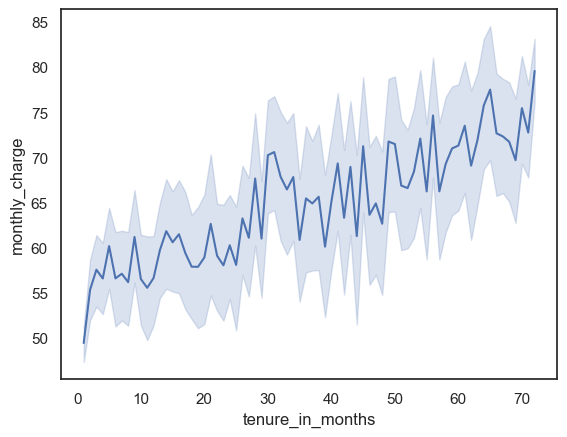

In [11]:
sns.lineplot(data = df, x='tenure_in_months', y='monthly_charge')

- 가입 기간이 길수록 월별 요금이 증가하는 특징을 가지고 있다.
- Positive correlation between monthly charge and tenure

In [12]:
df['monthly_charge'].describe()

count    7043.000000
mean       63.596131
std        31.204743
min       -10.000000
25%        30.400000
50%        70.050000
75%        89.750000
max       118.750000
Name: monthly_charge, dtype: float64

In [13]:
df.groupby('customer_status').size()

customer_status
Churned    1869
Joined      454
Stayed     4720
dtype: int64

In [14]:
allCustomer = 1869+454+4720
churnRatio = 1869 / allCustomer * 100
churnRatio

26.536987079369588

In [15]:
joinRatio = 454 / allCustomer * 100
joinRatio

6.446116711628568

In [16]:
df.groupby('customer_status')['monthly_charge'].describe()

,count,mean,std,min,25%,50%,75%,max
customer_status,,,,,,,,
Churned,1869.0,73.347592,26.373764,-10.0,55.3000,79.500,94.20,118.35
Joined,454.0,42.775991,24.612329,-8.0,20.1625,43.975,64.35,107.95
Stayed,4720.0,61.737415,32.198758,-10.0,25.1000,65.600,89.55,118.75


- 26%에 해당하는 고객이 철회하고
- 6%에 해당하는 고객이 신규 가입했다.

철회고객에 포커스를 맞추어 철회를 막을 수 있어야 한다..

In [17]:
df.groupby('customer_status')['total_charges'].sum()

customer_status
Churned     2862926.90
Joined        35998.90
Stayed     13161799.44
Name: total_charges, dtype: float64

In [18]:
churned = df[df['customer_status'] == 'Churned']['total_charges'].sum()
joined = df[df['customer_status'] == 'Joined']['total_charges'].sum()
stayed = df[df['customer_status'] == 'Stayed']['total_charges'].sum()

lossRatio = churned / (stayed+joined+churned) * 100
lossRatio

17.82563898714701

- 26%에 해당하는 고객의 철회로 인해 통신사는 약 17%의 손실이 있다.

In [19]:
df.groupby(['customer_status', 'gender'])['monthly_charge'].describe()

count       mean        std   min      25%     50%  \
customer_status gender                                                        
Churned         Female   939.0  73.606656  26.093400 -10.0  59.6250  79.500   
                Male     930.0  73.086022  26.665339  -9.0  53.8750  79.500   
Joined          Female   211.0  43.374645  23.839314  -8.0  20.2250  44.000   
                Male     243.0  42.256173  25.301925  -8.0  20.1000  43.850   
Stayed          Female  2338.0  62.343926  32.085856 -10.0  25.2500  65.625   
                Male    2382.0  61.142107  32.304853 -10.0  25.0125  65.550   

                           75%     max  
customer_status gender                  
Churned         Female  93.625  117.45  
                Male    94.500  118.35  
Joined          Female  69.225   95.85  
                Male    60.800  107.95  
Stayed          Female  89.750  118.75  
                Male    89.375  118.20

- 성별은 철회와 상관이 없다
- Gender doesn't have to with churning

<AxesSubplot: xlabel='tenure_in_months', ylabel='total_revenue'>

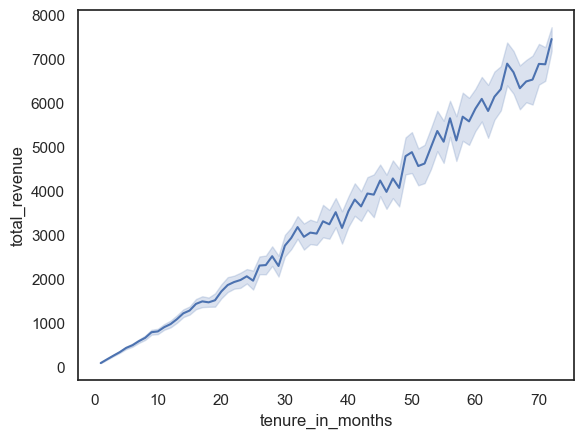

In [20]:
sns.lineplot(data = df, x='tenure_in_months', y='total_revenue')

- 가입기간이 길어질수록 총 수납한 요금이 많아지는 건 당연하다..

##### 주소 관련 정보 삭제

In [21]:
df.groupby('zip_code')['total_long_distance_charges'].describe()

,count,mean,std,min,25%,50%,75%,max
zip_code,,,,,,,,
90001,4.0,327.9925,628.505525,0.00,0.0000,20.840,348.8325,1270.29
90002,4.0,1014.7350,562.478014,581.06,602.7350,846.700,1258.7000,1784.48
90003,5.0,230.1620,412.218495,20.94,43.5700,57.540,61.7500,967.01
90004,5.0,325.9780,448.154537,0.00,3.0900,133.380,429.1200,1064.30
90005,4.0,449.3675,445.533807,18.24,104.3325,416.615,761.6500,946.00
...,...,...,...,...,...,...,...,...
96143,4.0,555.5375,547.571228,87.24,99.2100,479.055,935.3825,1176.80
96145,3.0,1199.0900,962.750386,309.96,687.8550,1065.750,1643.6550,2221.56
96146,4.0,534.4650,559.159660,45.12,57.5850,499.470,976.3500,1093.80


In [22]:
df.groupby('zip_code').size()
df.groupby('zip_code').size().max()
df.groupby('zip_code').size().mean()

4.331488314883149

<AxesSubplot: xlabel='longitude', ylabel='latitude'>

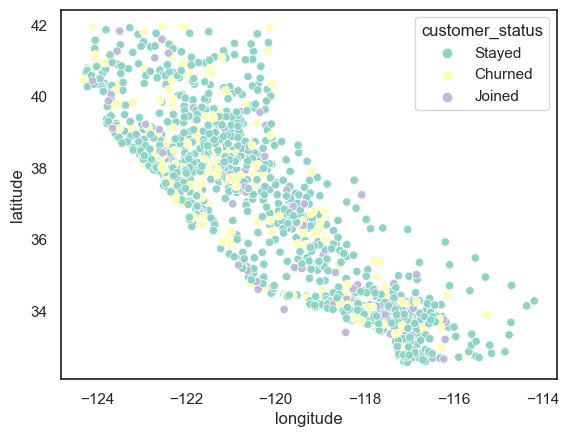

In [23]:
sns.scatterplot(data = df, x='longitude', y='latitude', hue='customer_status', palette = 'Set3')

- 한 우편번호 당 최대 43명이 살고 있는 구역도 있지만
- 평균 4.5명의 고객이 살고 있다.
- 지역별로 보았을 때 한 곳에 이탈고객이 몰려있거나 하는 특징이 없다.

In [24]:
df = df.drop(columns=['zip_code', 'latitude', 'longitude', 'city'])
df.columns

Index(['customer_id', 'gender', 'age', 'married', 'number_of_dependents',
       'number_of_referrals', 'tenure_in_months', 'offer', 'phone_service',
       'avg_monthly_long_distance_charges', 'multiple_lines',
       'internet_service', 'internet_type', 'avg_monthly_gb_download',
       'online_security', 'online_backup', 'device_protection_plan',
       'premium_tech_support', 'streaming_tv', 'streaming_movies',
       'streaming_music', 'unlimited_data', 'contract', 'paperless_billing',
       'payment_method', 'monthly_charge', 'total_charges', 'total_refunds',
       'total_extra_data_charges', 'total_long_distance_charges',
       'total_revenue', 'customer_status', 'churn_category', 'churn_reason',
       'churn'],
      dtype='object')

# 4. 기본 전처리 끝

In [25]:
df.to_csv('clearned_churn.csv')

# 5. EDA

##### 그룹 미구분 - 수치형 컬럼 시각화

age                                     AxesSubplot(0.125,0.653529;0.168478x0.226471)
number_of_dependents                 AxesSubplot(0.327174,0.653529;0.168478x0.226471)
number_of_referrals                  AxesSubplot(0.529348,0.653529;0.168478x0.226471)
tenure_in_months                     AxesSubplot(0.731522,0.653529;0.168478x0.226471)
avg_monthly_long_distance_charges       AxesSubplot(0.125,0.381765;0.168478x0.226471)
avg_monthly_gb_download              AxesSubplot(0.327174,0.381765;0.168478x0.226471)
monthly_charge                       AxesSubplot(0.529348,0.381765;0.168478x0.226471)
total_charges                        AxesSubplot(0.731522,0.381765;0.168478x0.226471)
total_refunds                               AxesSubplot(0.125,0.11;0.168478x0.226471)
total_extra_data_charges                 AxesSubplot(0.327174,0.11;0.168478x0.226471)
total_long_distance_charges              AxesSubplot(0.529348,0.11;0.168478x0.226471)
total_revenue                            AxesSubplot(0

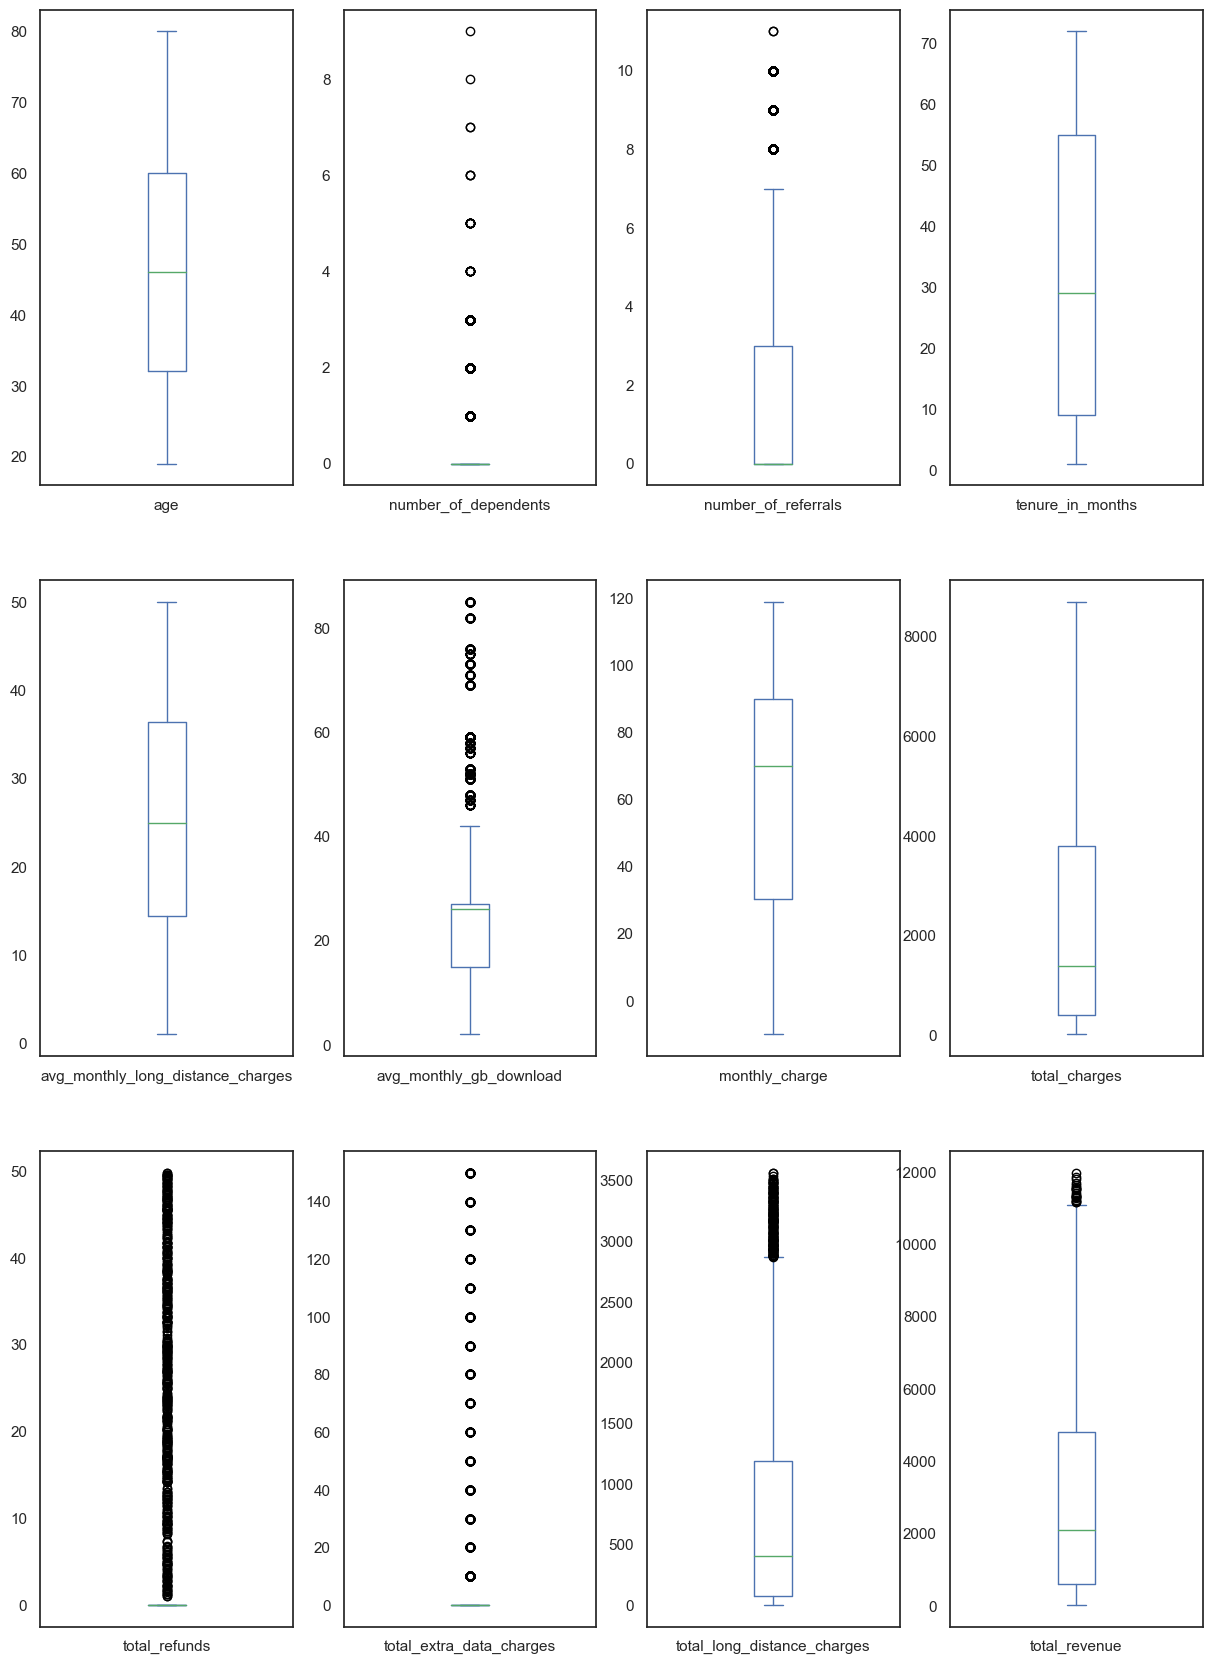

In [26]:
df.plot(kind='box', subplots=True, layout=(3, 4), figsize=(15, 21))
# 수치형 컬럼

1. 문제가 될만한 이상치는 없다고 할 수 있는가?
- number of dependents
- total refunds
- total extra data charges
의 경우에는 이상치가 전부인데.. 컬럼 자체를 제거해야 마땅한가?

2. number of referrals 컬럼의 경우 추천인 수가 많은 고객의 특징이 따로 있을 가능성 -> 확인 필요


##### 그룹 구분 수치형 컬럼

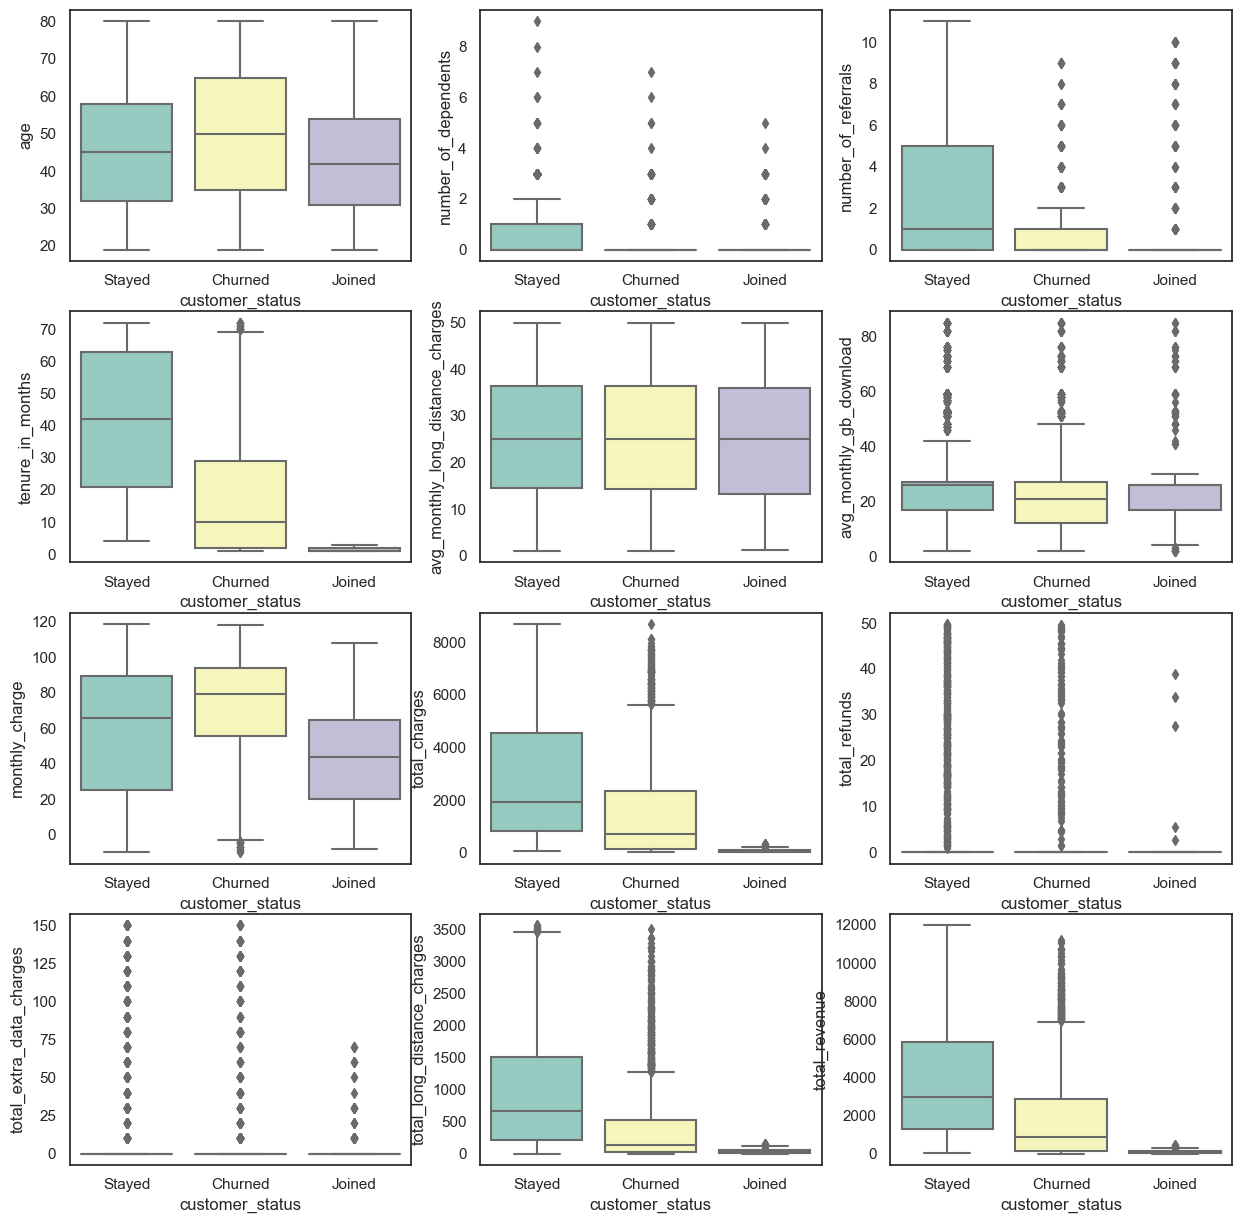

In [27]:
number_col = ['age', 'number_of_dependents', 'number_of_referrals', 'tenure_in_months', 'avg_monthly_long_distance_charges',
              'avg_monthly_gb_download', 'monthly_charge', 'total_charges', 'total_refunds', 'total_extra_data_charges',
              'total_long_distance_charges', 'total_revenue']

fig, ax = plt.subplots(4, 3, figsize = (15,15))
for i, subplot in zip(number_col, ax.flatten()):
    sns.boxplot(x = 'customer_status', y = i , data = df, ax = subplot, palette = 'Set3')

1. joined 고객을 따로 살펴봐야하는 이유가 있는지 어디서 인사이트를 얻징?
2. 대부분의 유지고객은 부양가족이 없다.
3. 이탈 고객의 월간 요금 중앙값이 충성 고객의 월간 요금 중앙값보다 높다.
    - 요금이 너무 높으면 고객이 이탈할 가능성이 더 높다고 생각할 수 있다.
    - 또는 높은 요금을 사용하는 메리트가 없다는 의미이다.
4. 통신 서비스의 월별 장거리 통화 요금은 그룹별로 차이가 없다.

In [28]:
df.groupby('customer_status')['total_refunds'].max()

customer_status
Churned    49.57
Joined     38.84
Stayed     49.79
Name: total_refunds, dtype: float64

- 그룹 별 환불 금액의 평균값, 최대값이 모두 크지 않으므로 total_refunds 삭제 

In [29]:
# df = df.drop(columns=['total_refunds'])
# df.columns

##### 그룹 미구분 범주형 컬럼

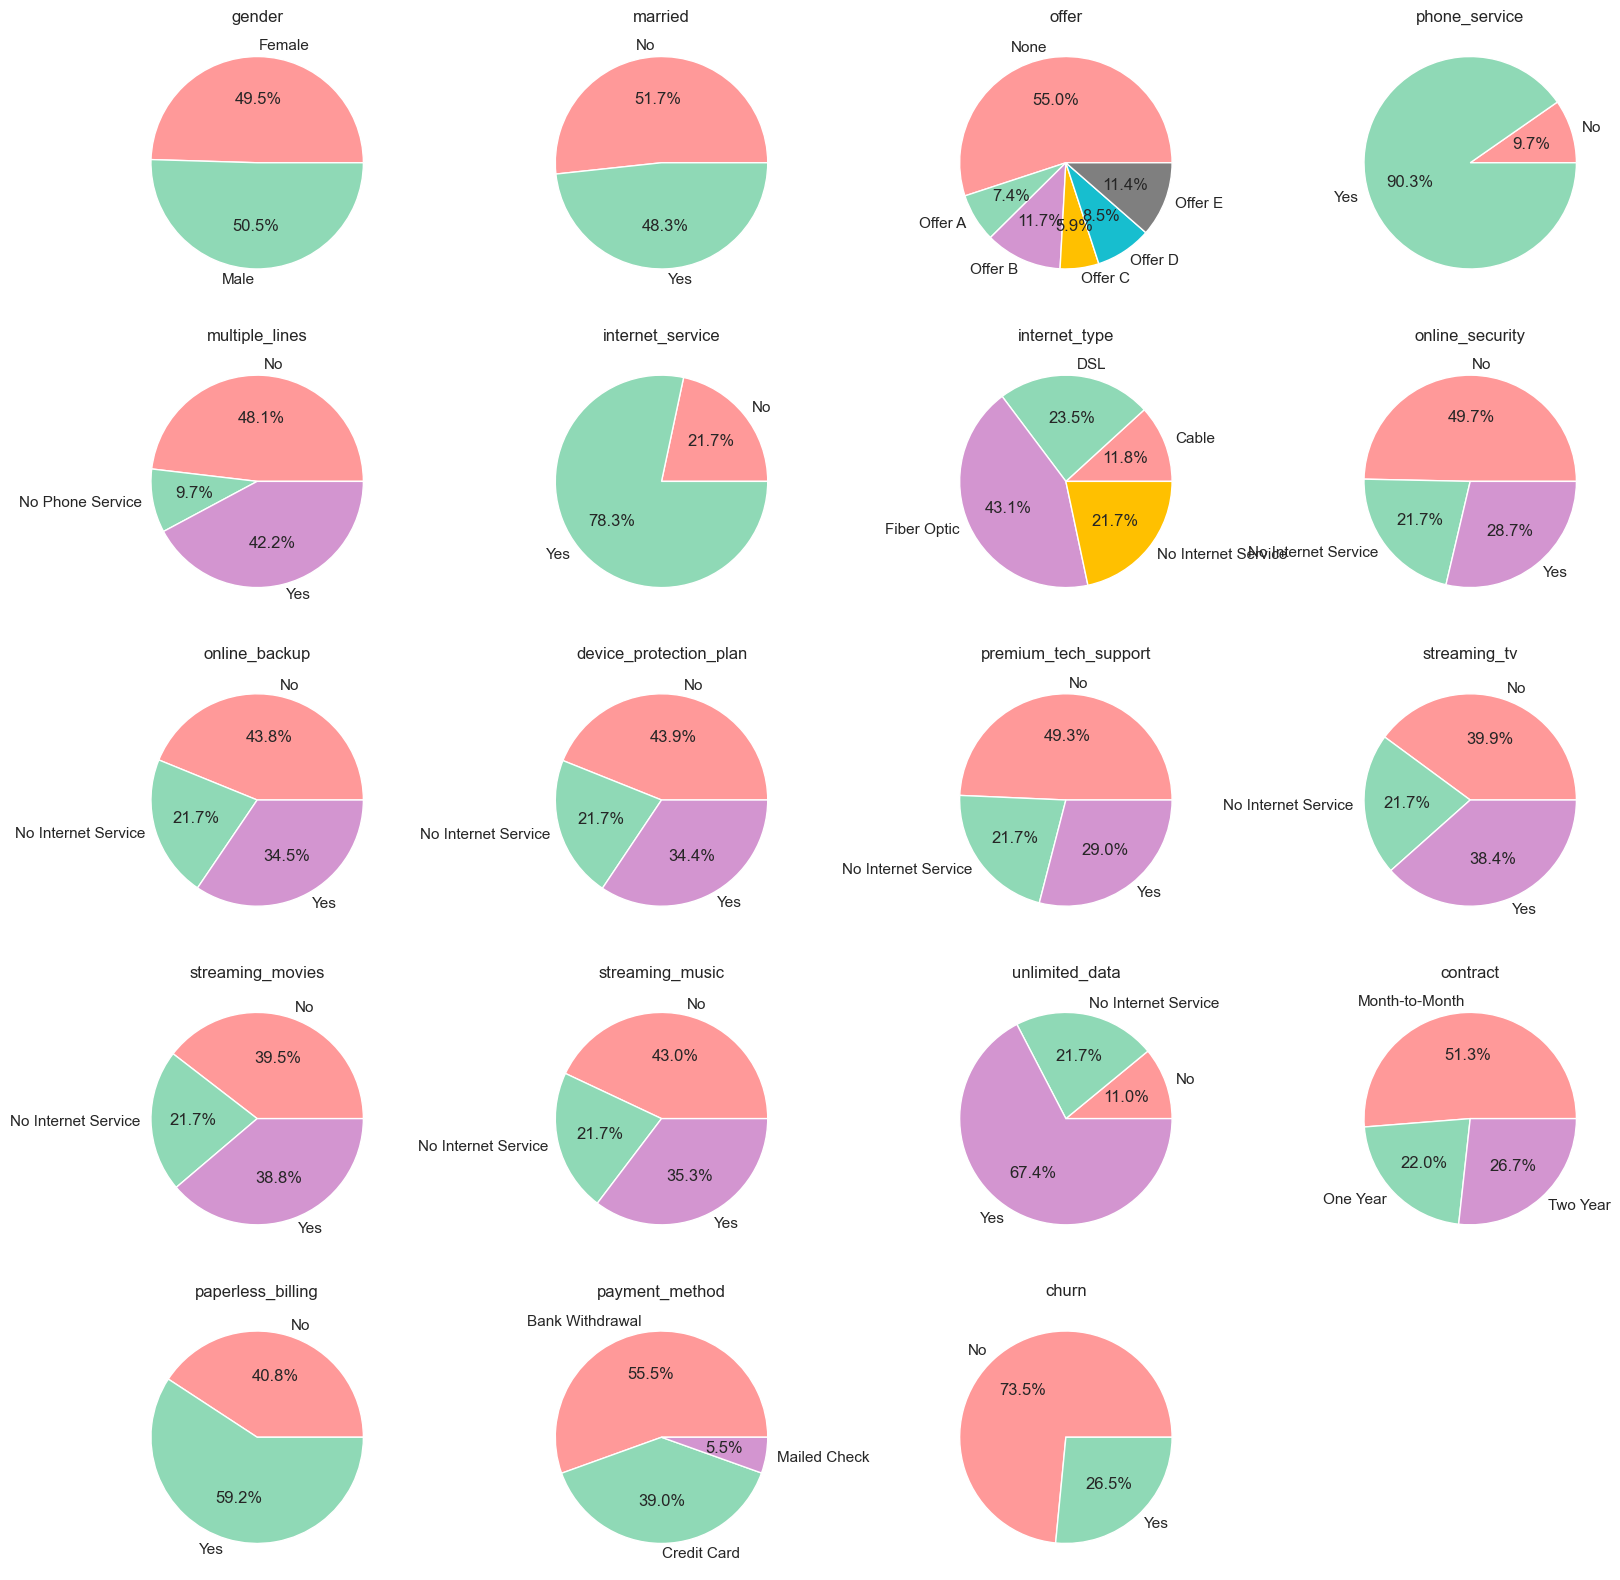

In [30]:
object_col = ['gender', 'married', 'offer', 'phone_service', 'multiple_lines', 'internet_service', 'internet_type',
              'online_security', 'online_backup', 'device_protection_plan', 'premium_tech_support', 'streaming_tv',
              'streaming_movies', 'streaming_music', 'unlimited_data', 'contract', 'paperless_billing', 'payment_method',
             'churn']
_ = df[object_col]
colors = ['#ff9999', '#8fd9b6', '#d395d0', '#ffc000', '#17becf', '#7f7f7f']

fig = plt.figure(figsize = (20, 20))
i = 1
for a in df[object_col].columns:
    plt.subplot(5, 4, i)
    ax = df.groupby([a]).size().plot(kind = 'pie', autopct = '%.1f%%', colors = colors)
    ax.set(xlabel = None, ylabel = None)
    plt.title(str(a), loc='center')
    i += 1

##### 그룹별 범주형 컬럼

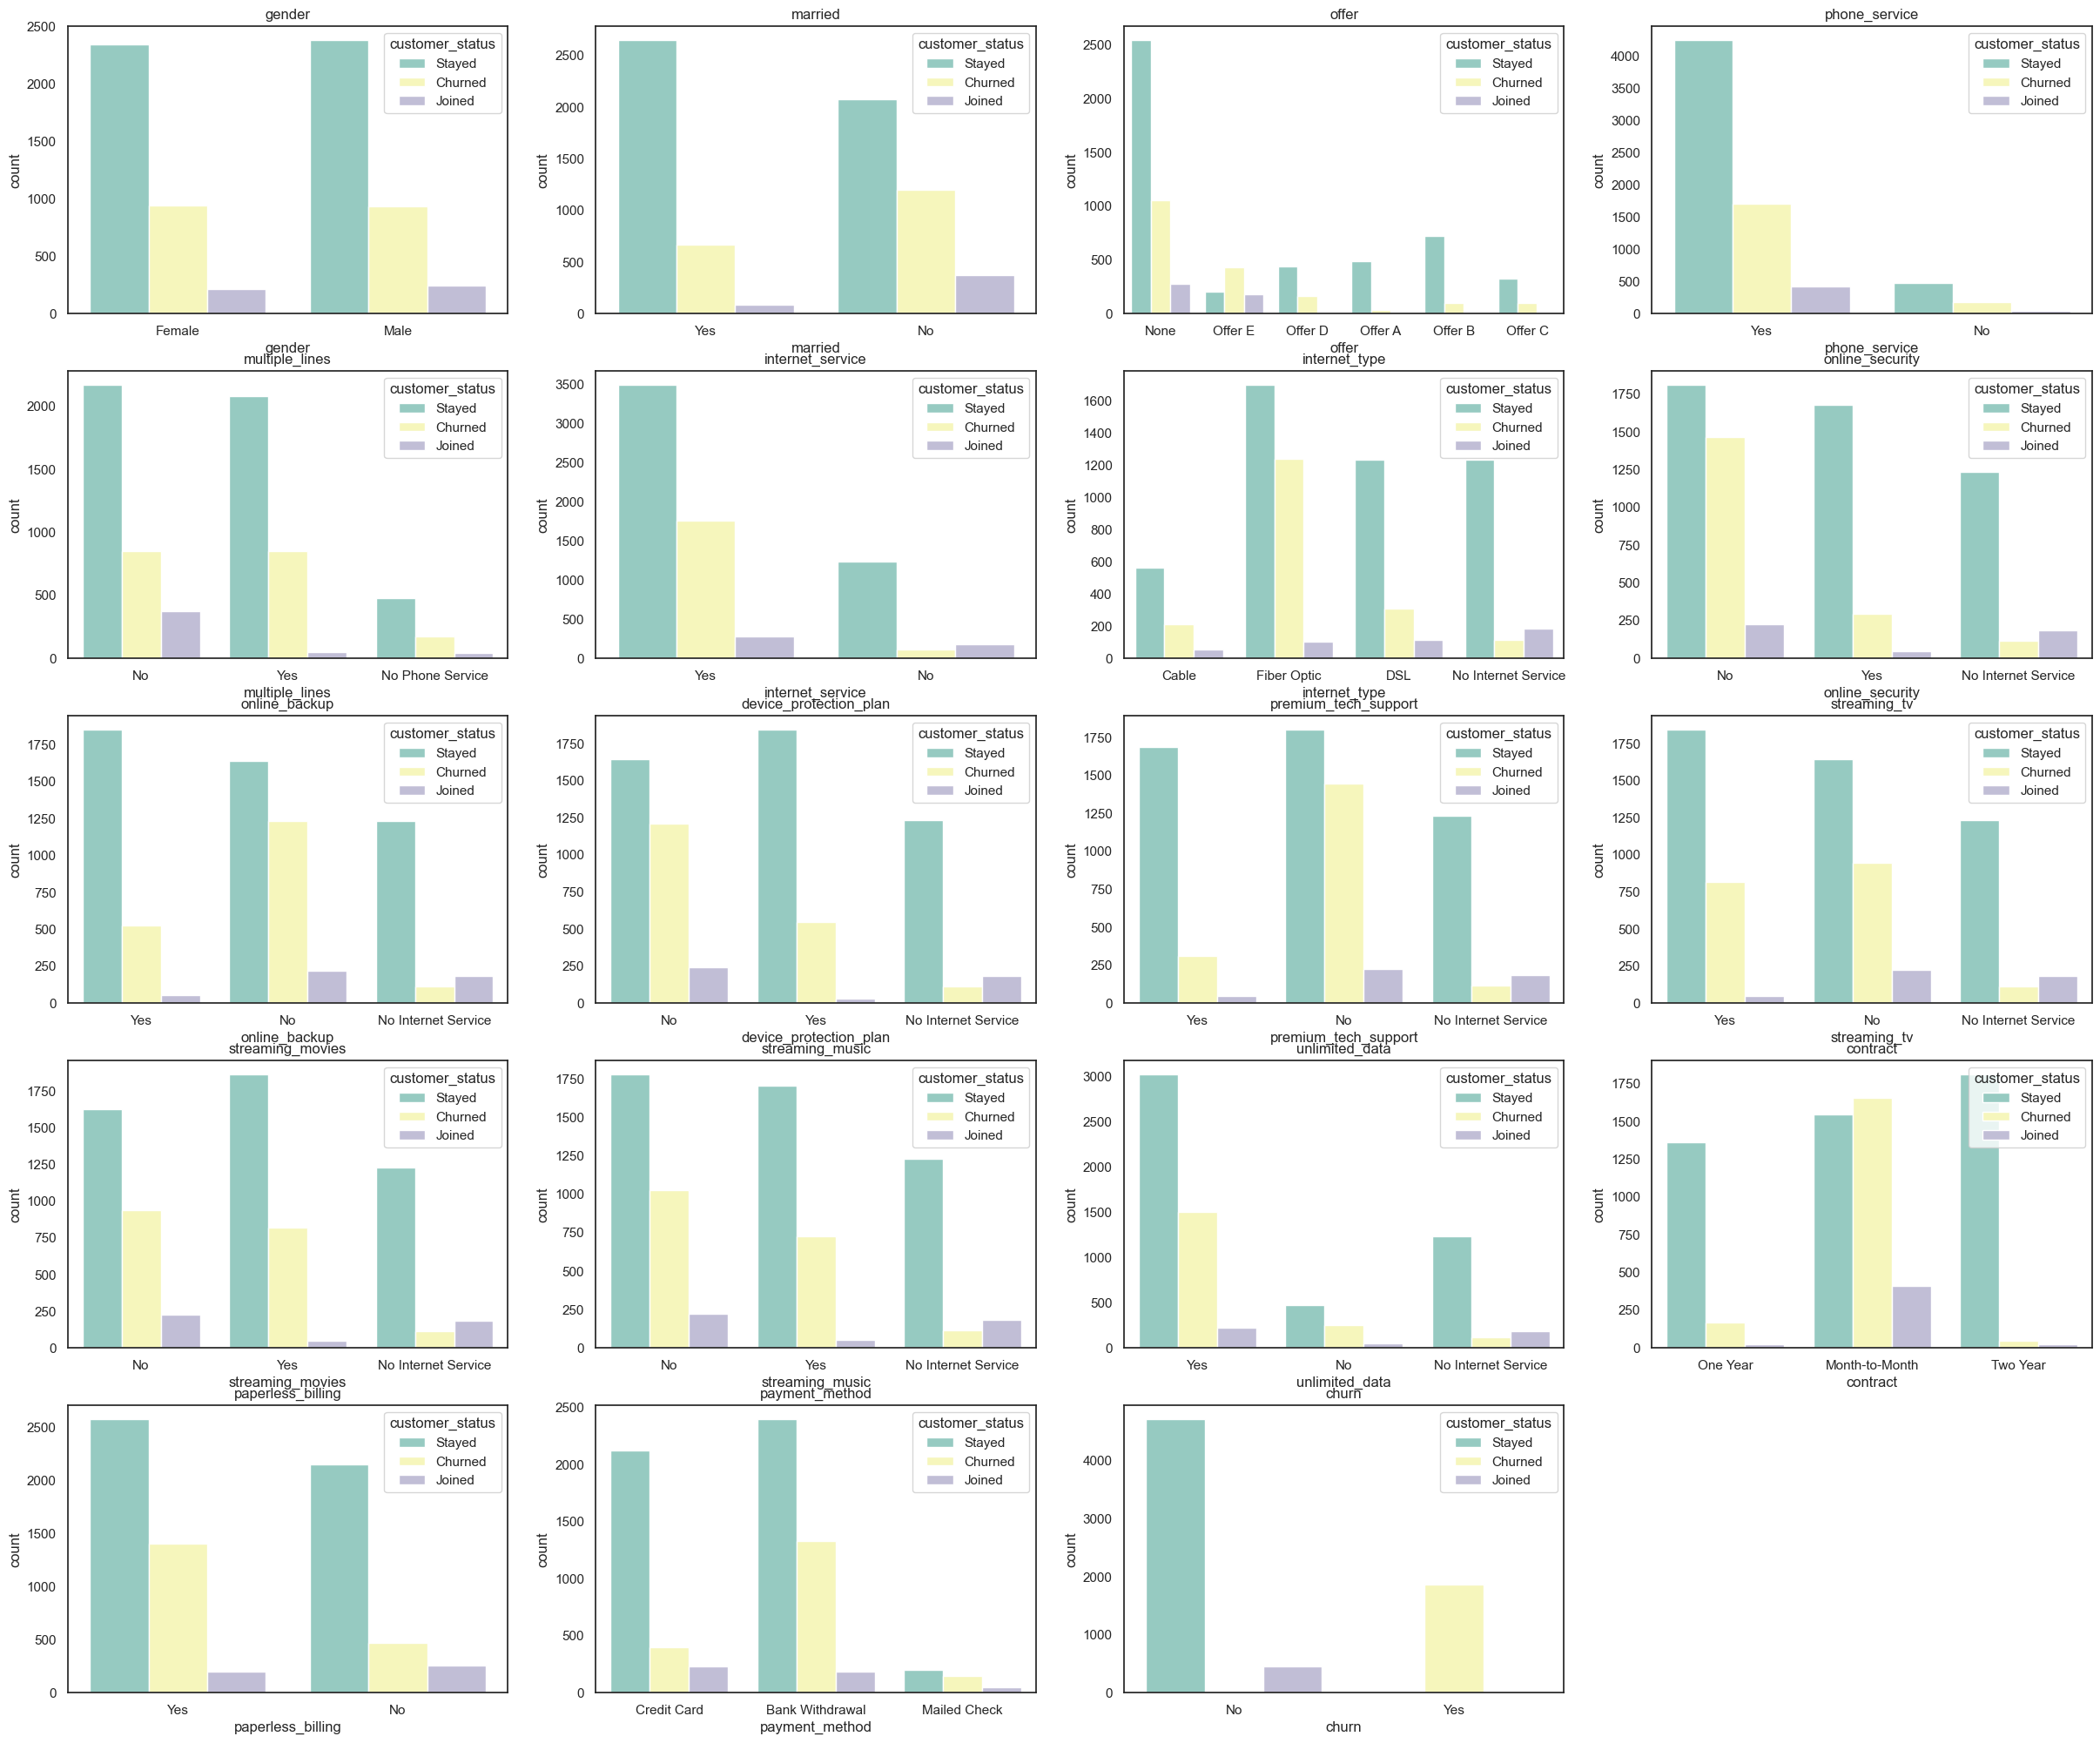

In [31]:
object_col = ['gender', 'married', 'offer', 'phone_service', 'multiple_lines', 'internet_service', 'internet_type',
              'online_security', 'online_backup', 'device_protection_plan', 'premium_tech_support', 'streaming_tv',
              'streaming_movies', 'streaming_music', 'unlimited_data', 'contract', 'paperless_billing', 'payment_method',
             'churn'] # 'churn_category', 'customer_status']
plt.figure(figsize=(30,30))

for i, col in enumerate(object_col):
    ax = plt.subplot(6, 4, i+1)
    sns.countplot(x =str(col), hue = 'customer_status', data = df, palette = 'Set3')
    ax.set_title(f"{col}")
    
    

1. 성별은 유지/철회에 영향이 없다.
2. 결혼 여부 역시 유지/철회에 영향이 없지만, 유지 고객의 경우 미혼이 상대적으로 많다.
3. 아무 마케팅을 수락하지 않은 고객이 유지하는 경우가 상대적으로 높다.
    - Offer E의 경우 철회하는 고객이 상대적으로 많다. Offer E와 같은 마케팅은 좋지 않을 수 있다.
    - Offer B, 그다음은 A와 D의 순서로 유지하는 고객이 상대적으로 많다.
4. 통신 서비스를 이용하는 유지고객이 많다. 통신 서비스에 대한 만족도가 높다고 추정할 수 있다.
    - 반대로, 통신 서비스에 대한 특별한 점은 없기에 철회 고객의 비율에도 차이가 없다고 할 수 있다.
    - 마케팅에 있어서 통신 서비스에 대한 오퍼가 있으면 좋을 수 있다.
    - 다중 회선의 경우 영향이 없다.
    - 인터넷 서비스와 통신 서비스의 이용비율이 그룹별로 비슷한 것을 확인할 수 있다.
        - 통신 서비스와 다른 점은 어떤 인터넷을 사용하느냐에 따라 철회고객이 많아졌다 (Fiber Optic)
        - 유지 고객의 경우 인터넷 종속 서비스를 사용하는 고객과 그렇지 않은 고객의 비율이 비슷했다.
        - 철회 고객의 경우에는 인터넷 보안을 사용하지 않는 경우가 월등히 많다.
        - 철회 고객의 경우에는 온라인 백업을 사용하지 않는 고객이 상대적으로 많다.
        - 철회 고객의 경우에는 기기 보호 약정을 사용하지 않는 고객이 상대적으로 많다.
        - 철회 고객의 경우에는 프리미엄 기술 지원을 사용하지 않는 고객이 상대적으로 많다.
        - 철회 고객, 유지 고객 모두 스트리밍 서비스 (영화, 음악, TV)에 대한 비율이 비슷하므로 영향을 미치지 않는다.
        
    - 마케팅 측면에서 인터넷 서비스 관련 종속 서비스를 적극 홍보하고 오퍼로서 제안하는 것이 좋을 수 있다.
5. 무제한 데이터를 사용하는 유지/철회 고객이 상대적으로 많다.
    - 철회고객의 경우 무제한 데이터가 맘에 안들었을 수도 있다.. 그럼 유지 고객은 왜 쓰지?
6. 월별 계약으로 가입하는 신규고객과 철회고객이 상대적으로 많다.
    - 가입 장벽이 낮다고 추정할 수 있으나, 그 이상의 메리트가 없기에 철회할 가능성이 있을 수 있다.
7. 종이 영수증을 받는 고객의 경우 철회 비율이 상대적으로 높다.
    - 전자식으로 가입할 수 있도록 유도하는 것이 좋다.
8. 계좌 인출로 요금을 납부하는 고객의 경우 철회 고객의 비율이 상대적으로 높다.
    - 신용카드 요금 납부를 할 수 있도록 유도하는 것이 좋다.

##### 철회 이유

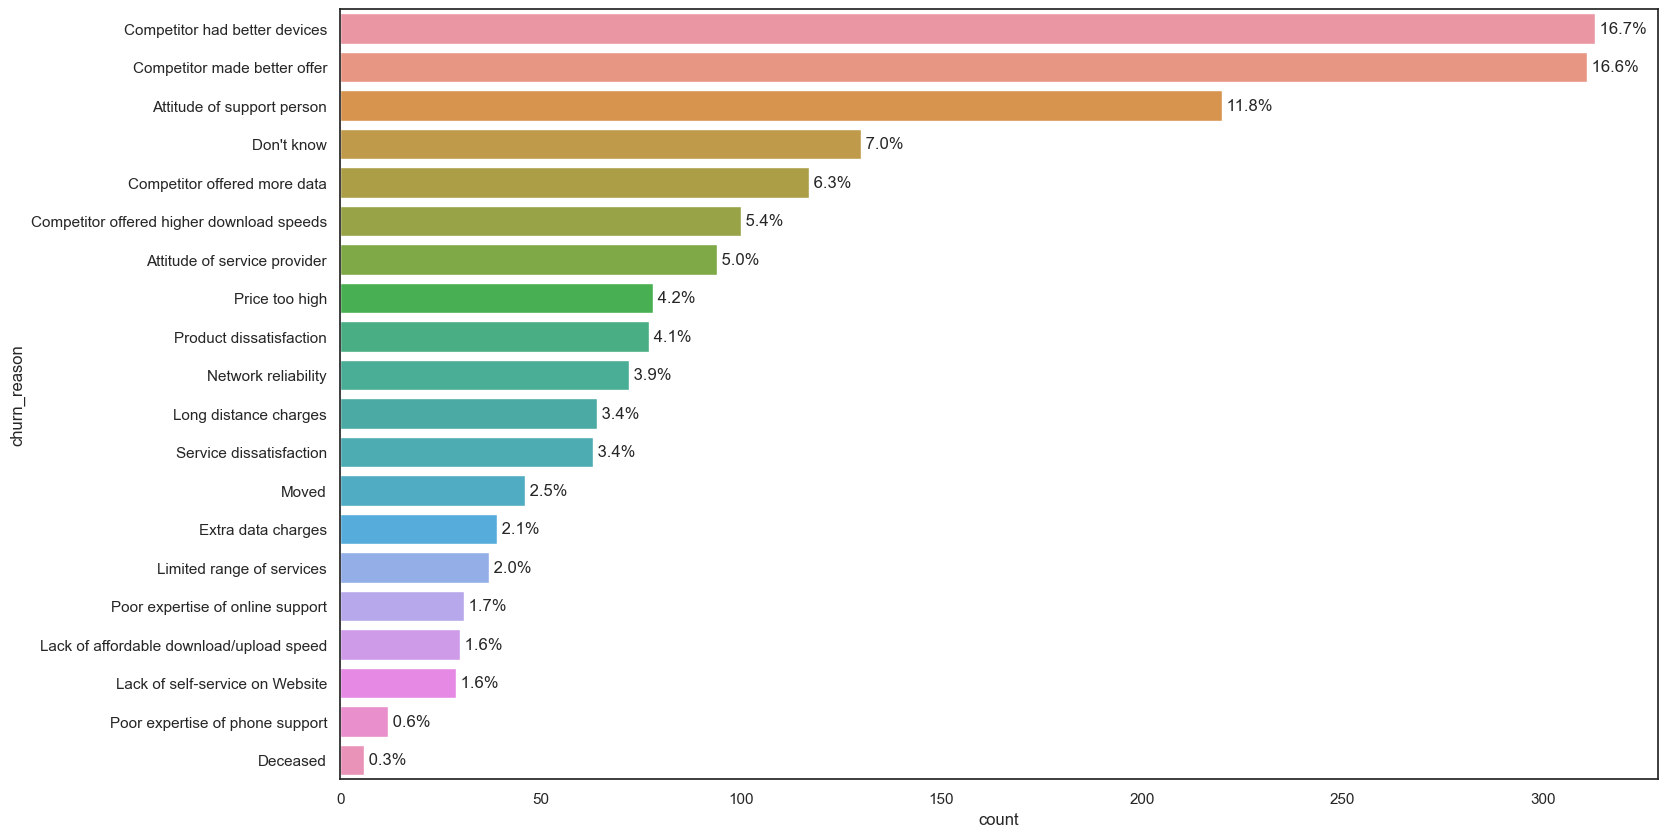

In [32]:
fig, ax = plt.subplots(figsize=(17,10))
churn_reason = df['churn_reason'].dropna()

sns.countplot(data = df, 
              y = churn_reason, 
              ax = ax, 
              order = df['churn_reason'].value_counts().index)
total = len(churn_reason)

for p in ax.patches: # ax.patches = 그래프의 각 막대에 대한 작업을 수행한다.
    # 비율 계산 : 각 churn reason 비율!
    percentage = '{:.1f}%'.format(100 * p.get_width() / total)
    # 막대 너비 p.get_width(), 즉 count이다.
    # 각 막대의 카운트를 전체 막대 수에 대한 백분율로 계산하고, '{:.1f}%' 소수점 첫째자리까지 나타낸다.
    
    # 비율을 표시할 위치 설정
    x = p.get_x() + p.get_width() # x축 기준 막대의 오른쪽 끝에 표시하겠다 
    y = p.get_y() + p.get_height() / 2 # y 축 기준 막대의 중앙에 표시하겠다
    
    # 주석 표시
    ax.annotate(' ' + percentage, (x, y), ha = 'left', va = 'center', fontsize = 12)
    # ' percentage' 를 주석으로 표시, (x, y) 위치에다가,
    # ha = 'left' 어노테이션은 왼쪽 정렬, va = 'center' 수직 중앙 정렬
plt.show()

1. 경쟁사의 더 나은 기기와 더 나은 오퍼가 철회에 있어서 가장 큰 이유를 차지하고 있다.
    - 앞서 살펴본 그룹별 특징을 보아서 통신사는 마케팅에 있어서 소극적인 태도를 취하고 있을 가능성이 높다. 왜냐하면 유지 고객의 경우 통신사가 제공하는 부가서비스를 적극적으로 이용하는 경우가 그렇지 않은 경우와 비슷했으나 철회 고객의 경우 전혀 사용하지 않는 경우가 많았기 때문이다.
    - 기기 지원 서비스의 경우에도 사용하지 않는 철회 고객이 상대적으로 많았다.
    - 통신사는 인터넷 관련 종속 서비스에 대한 홍보를 적극적으로 하고 종속 서비스에 대한 오퍼를 할 수 있어야 한다.

2. 직원 교육이 필요하다.

In [33]:
df.to_csv('clearned_churn.csv', index = False)

In [34]:
# df = pd.read_csv('clearned_churn.csv')
# df.head()

# 6. 데이터 인코딩

In [35]:
# 라벨 인코딩을 적용할 변수의 리스트 : object_col

# fit()과 transform()으로 라벨 인코딩을 수행
for feature in object_col:
    # LabelEncoder 객체 생성
    encoder = LabelEncoder()
    # fit, transform 메소드를 통한 레이블 인코딩
    encoder.fit(df[feature])
    df[feature] = encoder.transform(df[feature])

In [36]:
df

,customer_id,gender,age,married,number_of_dependents,number_of_referrals,tenure_in_months,offer,phone_service,avg_monthly_long_distance_charges,...,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,customer_status,churn_category,churn_reason,churn
0,0002-ORFBO,0,37,1,0,2,9,0,1,42.39,...,65.60,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN,0
1,0003-MKNFE,1,46,0,0,0,9,0,1,10.69,...,-4.00,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN,0
2,0004-TLHLJ,1,50,0,0,0,4,5,1,33.65,...,73.90,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices,1
3,0011-IGKFF,1,78,1,0,1,13,4,1,27.82,...,98.00,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction,1
4,0013-EXCHZ,0,75,1,0,3,3,0,1,7.38,...,83.90,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9987-LUTYD,0,20,0,0,0,13,4,1,46.68,...,55.15,742.90,0.00,0,606.84,1349.74,Stayed,NaN,NaN,0
7039,9992-RRAMN,1,40,1,0,1,22,4,1,16.20,...,85.10,1873.70,0.00,0,356.40,2230.10,Churned,Dissatisfaction,Product dissatisfaction,1
7040,9992-UJOEL,1,22,0,0,0,2,5,1,18.62,...,50.30,92.75,0.00,0,37.24,129.99,Joined,NaN,NaN,0
7041,9993-LHIEB,1,21,1,0,5,67,1,1,2.12,...,67.85,4627.65,0.00,0,142.04,4769.69,Stayed,NaN,NaN,0


In [37]:
# Label Encoding 결과 재복원
# print(encoder.inverse_transform(df["payment_method"]))

In [38]:
# 컬럼 삭제
df=df.drop(columns=['customer_id', 'total_refunds', 'churn_category','churn_reason'])

In [39]:
df.columns

Index(['gender', 'age', 'married', 'number_of_dependents',
       'number_of_referrals', 'tenure_in_months', 'offer', 'phone_service',
       'avg_monthly_long_distance_charges', 'multiple_lines',
       'internet_service', 'internet_type', 'avg_monthly_gb_download',
       'online_security', 'online_backup', 'device_protection_plan',
       'premium_tech_support', 'streaming_tv', 'streaming_movies',
       'streaming_music', 'unlimited_data', 'contract', 'paperless_billing',
       'payment_method', 'monthly_charge', 'total_charges',
       'total_extra_data_charges', 'total_long_distance_charges',
       'total_revenue', 'customer_status', 'churn'],
      dtype='object')

In [40]:
df.head()

,gender,age,married,number_of_dependents,number_of_referrals,tenure_in_months,offer,phone_service,avg_monthly_long_distance_charges,multiple_lines,...,contract,paperless_billing,payment_method,monthly_charge,total_charges,total_extra_data_charges,total_long_distance_charges,total_revenue,customer_status,churn
0,0,37,1,0,2,9,0,1,42.39,0,...,1,1,1,65.6,593.30,0,381.51,974.81,Stayed,0
1,1,46,0,0,0,9,0,1,10.69,2,...,0,0,1,-4.0,542.40,10,96.21,610.28,Stayed,0
2,1,50,0,0,0,4,5,1,33.65,0,...,0,1,0,73.9,280.85,0,134.60,415.45,Churned,1
3,1,78,1,0,1,13,4,1,27.82,0,...,0,1,0,98.0,1237.85,0,361.66,1599.51,Churned,1
4,0,75,1,0,3,3,0,1,7.38,0,...,0,1,1,83.9,267.40,0,22.14,289.54,Churned,1


# 7. 상관관계

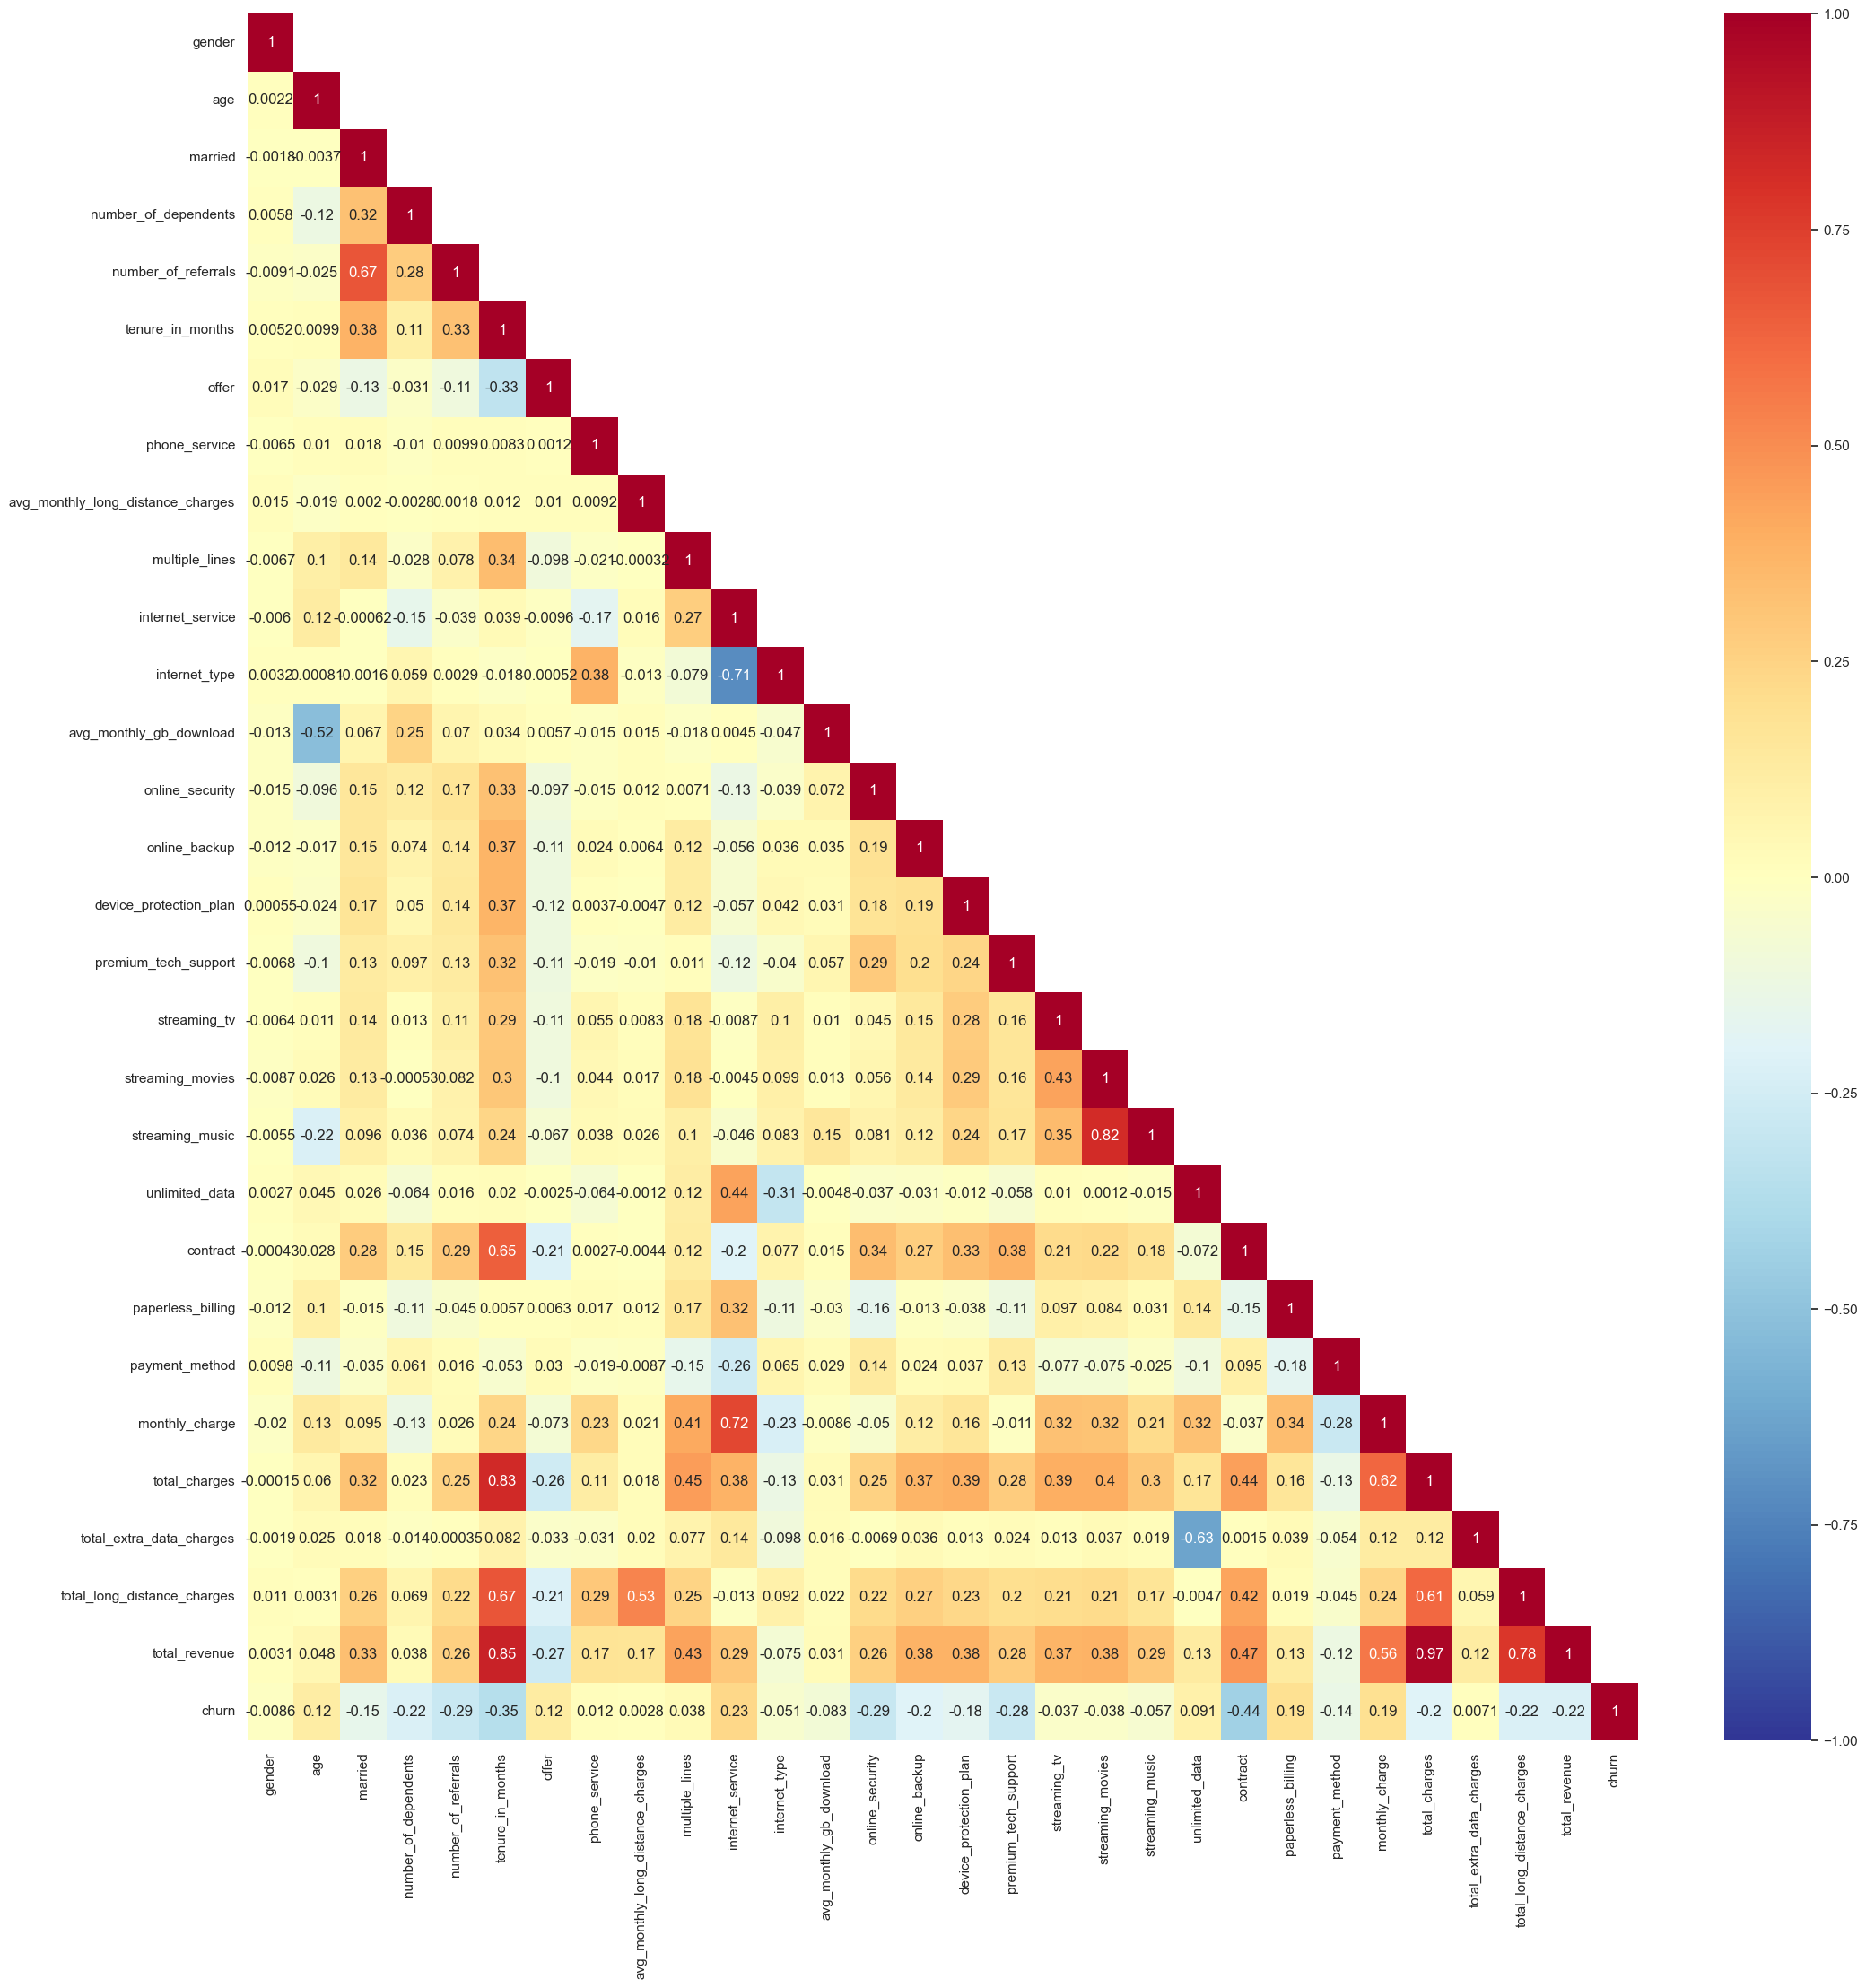

In [41]:
raw = df.corr()

plt.figure(figsize = (25, 25))
mask = np.array(raw)
mask[np.tril_indices_from(mask)] = False
sns.heatmap(raw, 
            annot = True, 
            mask = mask, 
            cmap = 'RdYlBu_r', 
            vmin = -1, vmax = 1)
plt.show()

**약한 상관관계**

total_refunds가 모든 컬럼과 상관관계가 약합니다.
gender가 모든 컬럼과 상관관계가 약합니다.


**강한 상관관계**

married & number_of_referrals : 0.67
- 가족 결합 상품..?

monthly_charge & internet_service : 0.72
- 월별 요금이 높을 수록 인터넷 서비스 이용을 하고 있습니다.
- 인터넷 서비스 요금이 높다고 추정할 수 있습니다.

tenure_in_months & total_revenue : 0.85
- 가입기간이 길수록 전체 납부 요금이 많습니다.

avg_monthly_long_distance_charges & total_long_distance_charges : 0.53
monthly_charge & total_revenue : 0.56
monthly_charge & total_charges : 0.62
total_charges & totla_revenue : 0.97 -> 총 수익은 누적 금액과 큰 관련이 있음은 당연한 이야기
- 당연함 포콤보 입니다..

streaming_music & streaming_movies : 0.85  -> streaming_music을 이용하는 고객은 streaming_movies도 이용할 가능성이 높습니다.
- 스트리밍 세트 서비스를 창출할 수 있습니다.

Total Revenue= Total Charges - Total Refurnds + Total Extra Data Charges + Total Lond Distance Charges

<AxesSubplot: >

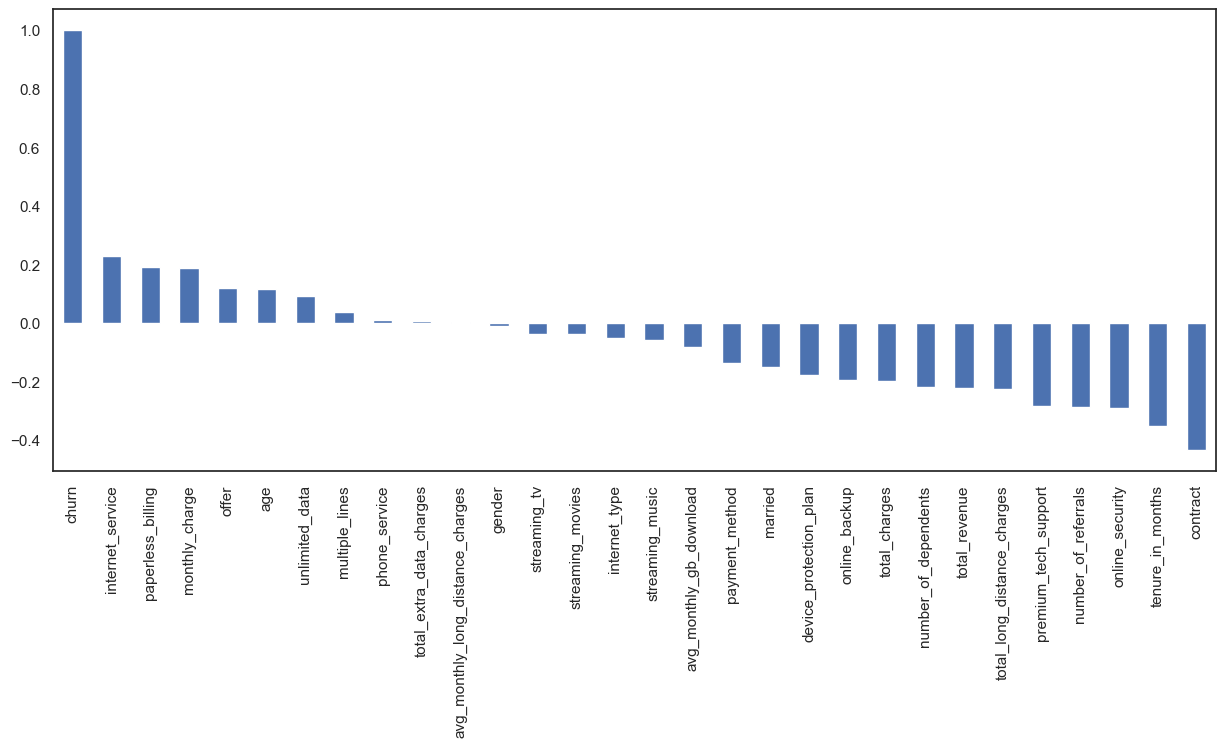

In [42]:
plt.figure(figsize=(15,6))
raw['churn'].sort_values(ascending = False).plot(kind='bar')

In [43]:
df.to_csv('encoding_churn.csv', index = False)